In [3]:
import pandas as pd

# Load the dataset
file_path = 'variant_summary.txt'  # Adjust the path as needed
data = pd.read_csv(file_path, sep='\t', low_memory=False)

# Display the first few rows
print(data.head())

# View the column names
print(data.columns)


   #AlleleID                       Type  \
0      15041                      Indel   
1      15041                      Indel   
2      15042                   Deletion   
3      15042                   Deletion   
4      15043  single nucleotide variant   

                                                Name  GeneID GeneSymbol  \
0  NM_014855.3(AP5Z1):c.80_83delinsTGCTGTAAACTGTA...    9907      AP5Z1   
1  NM_014855.3(AP5Z1):c.80_83delinsTGCTGTAAACTGTA...    9907      AP5Z1   
2     NM_014855.3(AP5Z1):c.1413_1426del (p.Leu473fs)    9907      AP5Z1   
3     NM_014855.3(AP5Z1):c.1413_1426del (p.Leu473fs)    9907      AP5Z1   
4       NM_014630.3(ZNF592):c.3136G>A (p.Gly1046Arg)    9640     ZNF592   

      HGNC_ID    ClinicalSignificance  ClinSigSimple LastEvaluated  \
0  HGNC:22197              Pathogenic              1             -   
1  HGNC:22197              Pathogenic              1             -   
2  HGNC:22197              Pathogenic              1  Jun 29, 2010   
3  HGNC:22

In [4]:
# Define relevant columns
relevant_columns = [
    'ClinicalSignificance',
    'GeneSymbol',
    'Chromosome',
    'Start',
    'ReferenceAllele',
    'AlternateAllele',
    'Type'  # Use 'Type' as a proxy for 'MolecularConsequence' if not available
]

# Ensure all selected columns are present
df = data[relevant_columns].copy()

# Display the first few rows
print(df.head())


     ClinicalSignificance GeneSymbol Chromosome     Start ReferenceAllele  \
0              Pathogenic      AP5Z1          7   4820844              na   
1              Pathogenic      AP5Z1          7   4781213              na   
2              Pathogenic      AP5Z1          7   4827361              na   
3              Pathogenic      AP5Z1          7   4787730              na   
4  Uncertain significance     ZNF592         15  85342440              na   

  AlternateAllele                       Type  
0              na                      Indel  
1              na                      Indel  
2              na                   Deletion  
3              na                   Deletion  
4              na  single nucleotide variant  


In [5]:
# Drop rows with missing values
df.dropna(subset=relevant_columns, inplace=True)
df.reset_index(drop=True, inplace=True)


In [6]:
# Keep only 'Pathogenic' and 'Benign' variants
df = df[df['ClinicalSignificance'].isin(['Pathogenic', 'Benign'])]

# Map target variable to binary labels
df['ClinicalSignificance'] = df['ClinicalSignificance'].map({'Benign': 0, 'Pathogenic': 1})

# Verify the mapping
print(df['ClinicalSignificance'].value_counts())


ClinicalSignificance
0    421746
1    355234
Name: count, dtype: int64


In [7]:
from sklearn.preprocessing import LabelEncoder

# Categorical features to encode
categorical_features = ['GeneSymbol', 'ReferenceAllele', 'AlternateAllele', 'Chromosome', 'Type']

# Initialize dictionaries to store label encoders and vocabulary sizes
label_encoders = {}
vocab_sizes = {}

for col in categorical_features:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    label_encoders[col] = le
    vocab_sizes[col] = df[col].nunique() + 1  # +1 for unseen categories


In [8]:
from sklearn.preprocessing import MinMaxScaler

# Initialize the scaler
scaler = MinMaxScaler()

# Scale the 'Start' position
df['Start'] = scaler.fit_transform(df[['Start']])


In [9]:
# Define target variable
y = df['ClinicalSignificance']

# Define numerical and categorical features
numerical_features = ['Start']


In [10]:
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    df, y, test_size=0.2, stratify=y, random_state=42
)


# Build the Neural Network with Embedding Layers

In [11]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, Dense, Concatenate, Flatten
from tensorflow.keras.models import Model


In [12]:
# Inputs for categorical features
input_layers = []
embedding_layers = []

for col in categorical_features:
    input_dim = vocab_sizes[col]
    output_dim = min(50, input_dim // 2)  # Set embedding dimension
    input_layer = Input(shape=(1,), name=f'{col}_input')
    embedding_layer = Embedding(input_dim=input_dim, output_dim=output_dim, name=f'{col}_emb')(input_layer)
    embedding_layer = Flatten()(embedding_layer)
    input_layers.append(input_layer)
    embedding_layers.append(embedding_layer)

# Input for numerical features
numerical_input = Input(shape=(len(numerical_features),), name='numerical_input')
input_layers.append(numerical_input)
embedding_layers.append(numerical_input)


In [13]:
# Concatenate all embedding and numerical layers
x = Concatenate()(embedding_layers)


In [14]:
# Add hidden layers
x = Dense(256, activation='relu')(x)
x = Dense(128, activation='relu')(x)
x = Dense(64, activation='relu')(x)


In [15]:
# Output layer
output = Dense(1, activation='sigmoid', name='output')(x)


In [16]:
# Define the model
model = Model(inputs=input_layers, outputs=output)

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Display the model architecture
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ GeneSymbol_input    │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ReferenceAllele_in… │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ AlternateAllele_in… │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Chromosome_input    │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Type_input          │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ GeneSymbol_emb      │ (None, 1, 50)     │    934,700 │ GeneSymbol_input… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ReferenceAllele_emb │ (None, 1, 7)      │        105 │ ReferenceAllele_… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ AlternateAllele_emb │ (None, 1, 12)     │        288 │ AlternateAllele_… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Chromosome_emb      │ (None, 1, 14)     │        392 │ Chromosome_input… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Type_emb            │ (None, 1, 7)      │        105 │ Type_input[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 50)        │          0 │ GeneSymbol_emb[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 7)         │          0 │ ReferenceAllele_… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_2 (Flatten) │ (None, 12)        │          0 │ AlternateAllele_… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_3 (Flatten) │ (None, 14)        │          0 │ Chromosome_emb[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_4 (Flatten) │ (None, 7)         │          0 │ Type_emb[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ numerical_input     │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 91)        │          0 │ flatten[0][0],    │
│ (Concatenate)       │                   │            │ flatten_1[0][0],  │
│                     │                   │            │ flatten_2[0][0],  │
│                     │                   │            │ flatten_3[0][0],  │
│                     │                   │            │ flatten_4[0][0],  │
│                     │                   │            │ numerical_input[

 Total params: 1,000,359 (3.82 MB)

 Trainable params: 1,000,359 (3.82 MB)

 Non-trainable params: 0 (0.00 B)

In [17]:
# Prepare training inputs
train_inputs = {}
for col in categorical_features:
    train_inputs[f'{col}_input'] = X_train[col].values
train_inputs['numerical_input'] = X_train[numerical_features].values

# Prepare testing inputs
test_inputs = {}
for col in categorical_features:
    test_inputs[f'{col}_input'] = X_test[col].values
test_inputs['numerical_input'] = X_test[numerical_features].values


In [18]:
# Train the model
history = model.fit(
    train_inputs, y_train,
    epochs=20,
    batch_size=64,
    validation_data=(test_inputs, y_test)
)


Epoch 1/20
9713/9713 ━━━━━━━━━━━━━━━━━━━━ 71s 7ms/step - accuracy: 0.7869 - loss: 0.4525 - val_accuracy: 0.8082 - val_loss: 0.4085
Epoch 2/20
9713/9713 ━━━━━━━━━━━━━━━━━━━━ 68s 7ms/step - accuracy: 0.8127 - loss: 0.3987 - val_accuracy: 0.8109 - val_loss: 0.4029
Epoch 3/20
9713/9713 ━━━━━━━━━━━━━━━━━━━━ 85s 7ms/step - accuracy: 0.8178 - loss: 0.3892 - val_accuracy: 0.8120 - val_loss: 0.4018
Epoch 4/20
9713/9713 ━━━━━━━━━━━━━━━━━━━━ 112s 12ms/step - accuracy: 0.8187 - loss: 0.3853 - val_accuracy: 0.8126 - val_loss: 0.4017
Epoch 5/20
9713/9713 ━━━━━━━━━━━━━━━━━━━━ 85s 9ms/step - accuracy: 0.8200 - loss: 0.3822 - val_accuracy: 0.8134 - val_loss: 0.3997
Epoch 6/20
9713/9713 ━━━━━━━━━━━━━━━━━━━━ 53s 5ms/step - accuracy: 0.8225 - loss: 0.3780 - val_accuracy: 0.8136 - val_loss: 0.3992
Epoch 7/20
9713/9713 ━━━━━━━━━━━━━━━━━━━━ 62s 6ms/step - accuracy: 0.8218 - loss: 0.3780 - val_accuracy: 0.8129 - val_loss: 0.4010
Epoch 8/20
9713/9713 ━━━━━━━━━━━━━━━━━━━━ 64s 7ms/step - accuracy: 0.8228 - loss:

In [19]:
# Evaluate the model
loss, accuracy = model.evaluate(test_inputs, y_test)
print(f'Test Accuracy: {accuracy * 100:.2f}%')


4857/4857 ━━━━━━━━━━━━━━━━━━━━ 5s 942us/step - accuracy: 0.8155 - loss: 0.4001
Test Accuracy: 81.38%


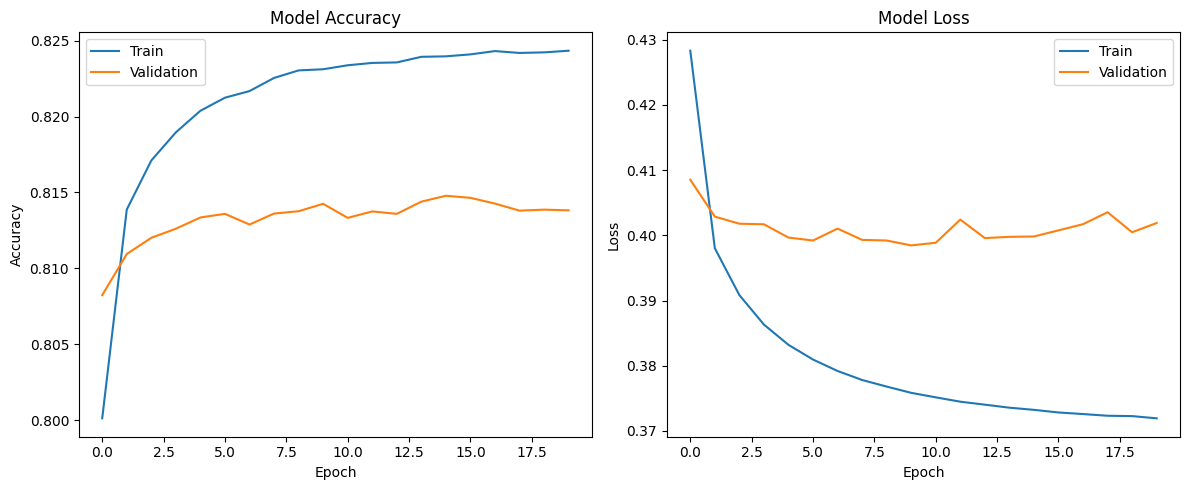

In [20]:
import matplotlib.pyplot as plt

# Plot accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [21]:
from sklearn.metrics import classification_report, confusion_matrix

# Make predictions
y_pred_prob = model.predict(test_inputs)
y_pred = (y_pred_prob > 0.5).astype(int).flatten()

# Classification report
print(classification_report(y_test, y_pred, target_names=['Benign', 'Pathogenic']))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
print('Confusion Matrix:\n', cm)


4857/4857 ━━━━━━━━━━━━━━━━━━━━ 5s 967us/step
              precision    recall  f1-score   support

      Benign       0.82      0.85      0.83     84349
  Pathogenic       0.81      0.77      0.79     71047

    accuracy                           0.81    155396
   macro avg       0.81      0.81      0.81    155396
weighted avg       0.81      0.81      0.81    155396

Confusion Matrix:
 [[71451 12898]
 [16033 55014]]


4857/4857 ━━━━━━━━━━━━━━━━━━━━ 3s 710us/step


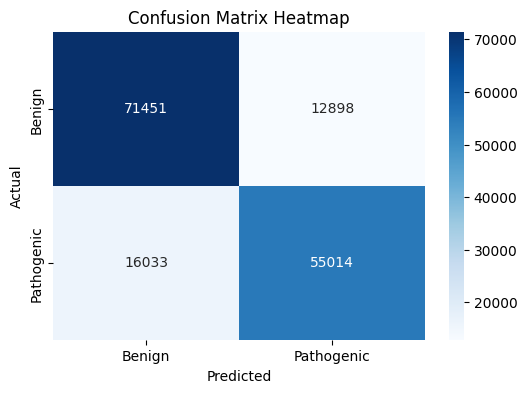

              precision    recall  f1-score   support

      Benign       0.82      0.85      0.83     84349
  Pathogenic       0.81      0.77      0.79     71047

    accuracy                           0.81    155396
   macro avg       0.81      0.81      0.81    155396
weighted avg       0.81      0.81      0.81    155396



In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Assume model has been trained and test_inputs, y_test are defined
# Make predictions on the test set
y_pred_prob = model.predict(test_inputs)
y_pred = (y_pred_prob > 0.5).astype(int).flatten()

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Define the labels
labels = ['Benign', 'Pathogenic']

# Create a DataFrame for the confusion matrix
cm_df = pd.DataFrame(cm, index=labels, columns=labels)

# Plot the heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix Heatmap')
plt.show()

# Generate and print the classification report
report = classification_report(y_test, y_pred, target_names=labels)
print(report)
